In [ ]:
# Reads in stellar spectrum, packs it on top of a 2D array to make it seem like it's real

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
from astropy.io import fits
from scipy.ndimage import gaussian_filter

In [2]:
stem_spec = '/Users/bandari/Documents/git.repos/rrlfe/src/model_spectra/rrmods_all/original_ascii_files'

In [3]:
spec_fake = pd.read_csv(stem_spec + '/700020m30.smo', delim_whitespace=True, names=['wavel','flux','noise'])

In [4]:
# normalize flux somehow
norm_val = 1000.
spec_fake['flux_norm'] = norm_val*np.divide(spec_fake['flux'],np.max(spec_fake['flux']))

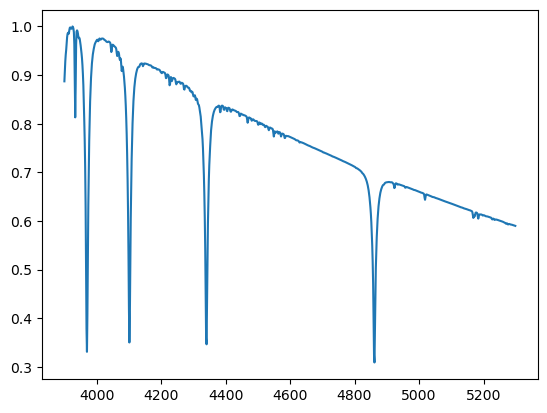

In [14]:
plt.plot(spec_fake['wavel'],spec_fake['flux_norm'])
plt.show()

In [5]:
# make separate array from the flux

#flux_2d_perfect = [np.array(spec_fake['flux_norm'])]

In [7]:
# array of spectrum

blank_2d = np.zeros((101,1000)) #np.shape(flux_2d_perfect)
spec_perfect = blank_2d
spec_perfect[51,:] = np.array(spec_fake['flux_norm'])

In [11]:
# array of ones: white-light
blank_2d = np.zeros((101,1000)) #np.shape(flux_2d_perfect)
spec_perfect = blank_2d
spec_perfect[51,:] = norm_val*np.ones(len(spec_fake['flux_norm']))


In [12]:
spec_convolved = gaussian_filter(spec_perfect, sigma=5)

In [13]:
test_rotate = scipy.ndimage.rotate(spec_convolved, 5)

In [15]:
np.max(test_rotate)

79.79165677873647

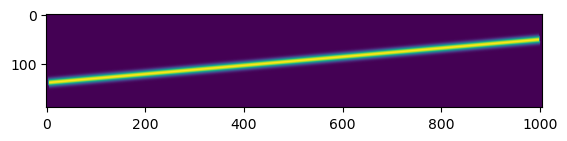

In [14]:
plt.imshow(test_rotate)
plt.show()

In [30]:
'''
# define noisy 2D array
array_2d_substrate = 0.01*np.random.normal(size=(300,2000))
'''
# or noiseless 2D array
array_2d_substrate = np.zeros((300,2000))

In [11]:
np.shape(test_rotate)

(188, 1005)

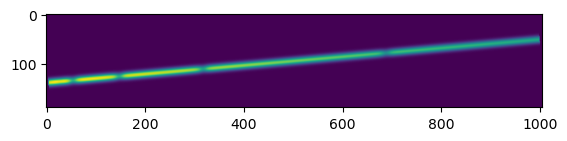

In [12]:
plt.imshow(test_rotate)
plt.show()

In [31]:
array_2d_w_spec = np.copy(array_2d_substrate)
del_x = np.shape(test_rotate)[0]
del_y = np.shape(test_rotate)[1]
array_2d_w_spec[0:0+del_x,100:100+del_y] += test_rotate

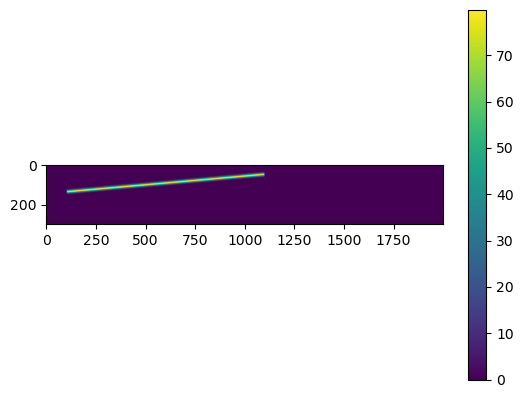

In [32]:
plt.imshow(array_2d_w_spec)
plt.colorbar()
plt.show()

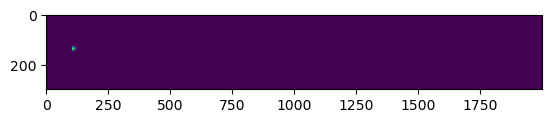

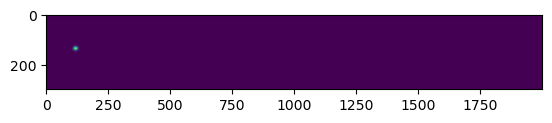

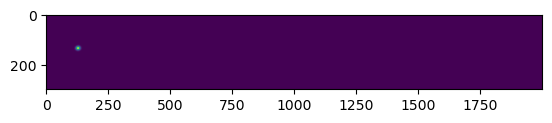

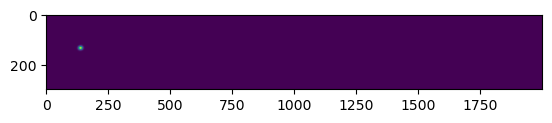

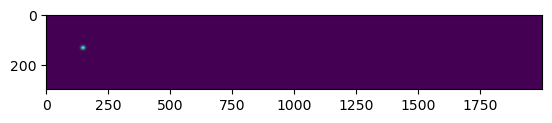

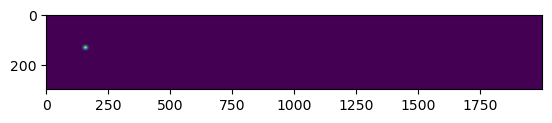

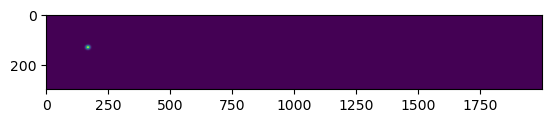

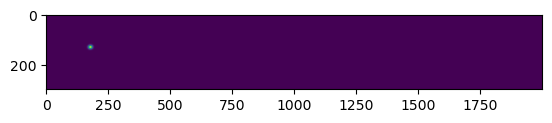

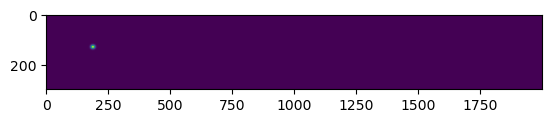

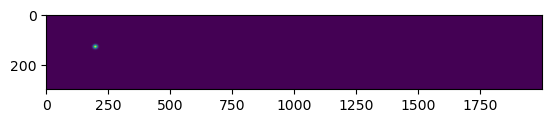

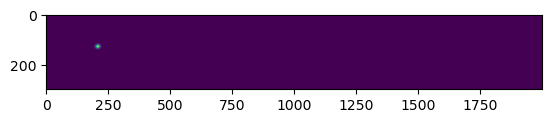

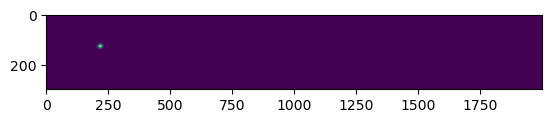

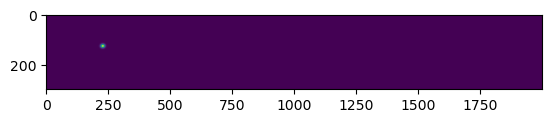

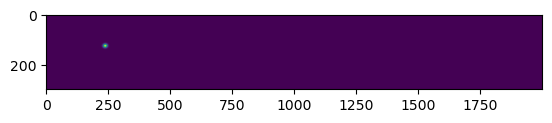

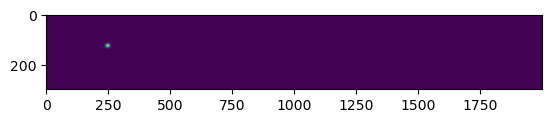

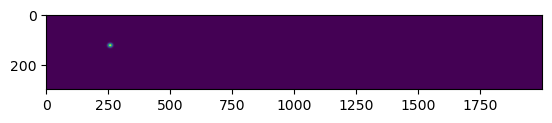

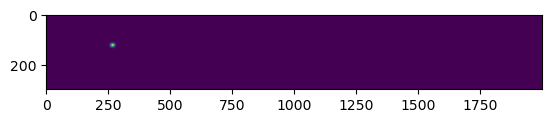

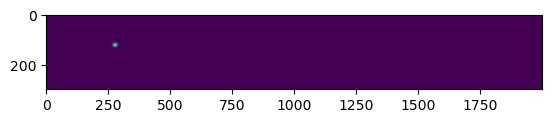

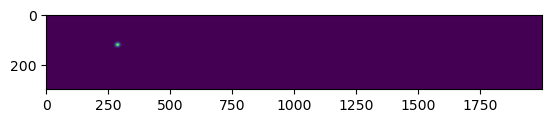

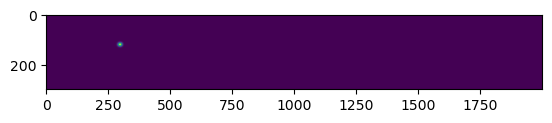

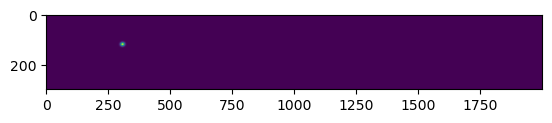

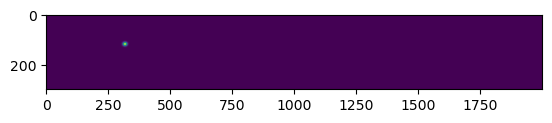

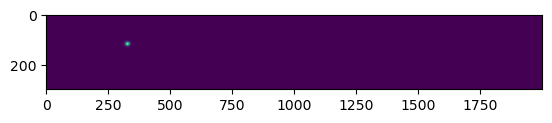

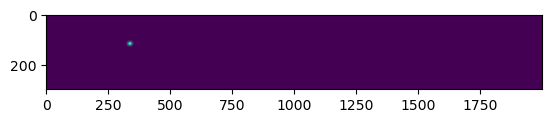

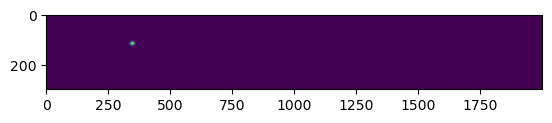

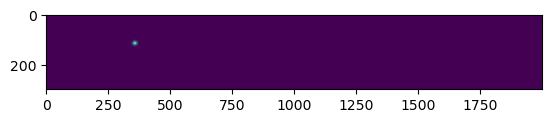

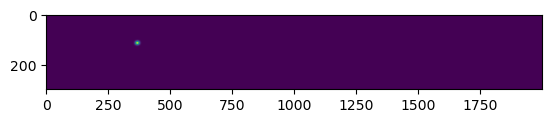

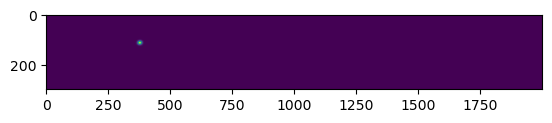

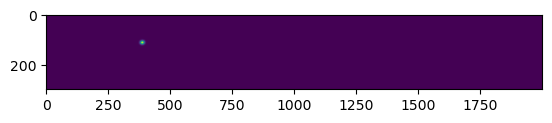

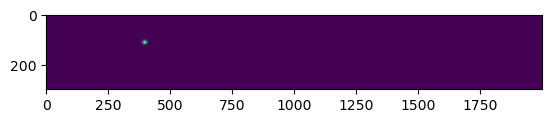

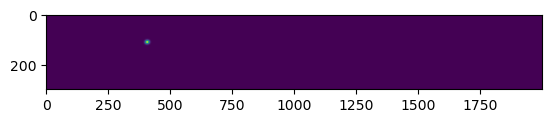

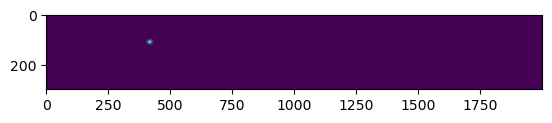

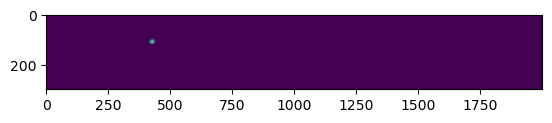

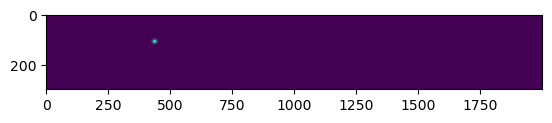

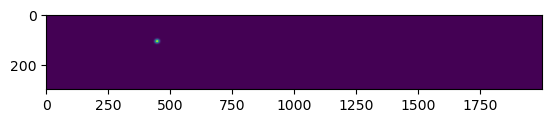

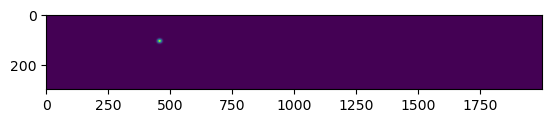

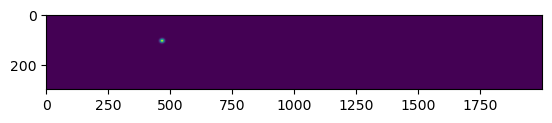

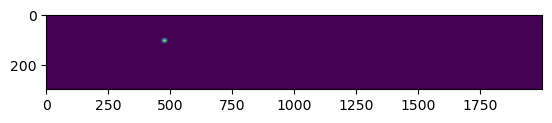

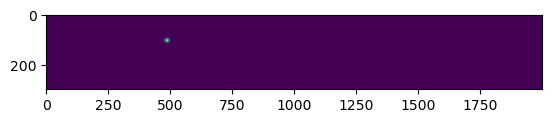

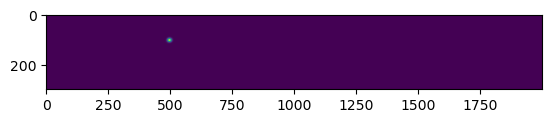

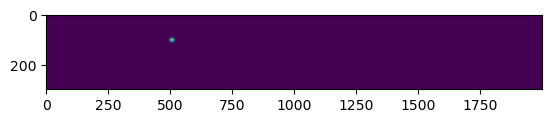

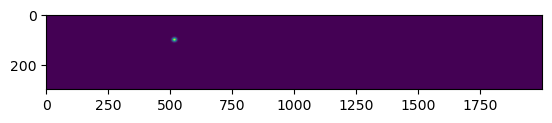

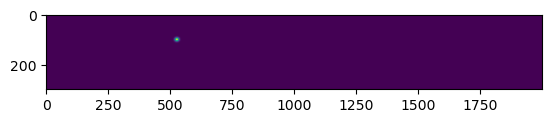

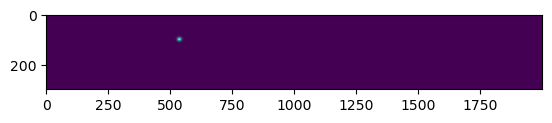

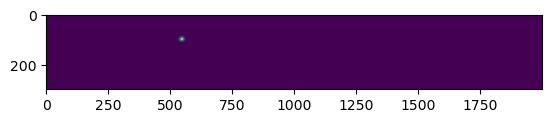

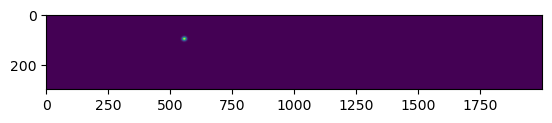

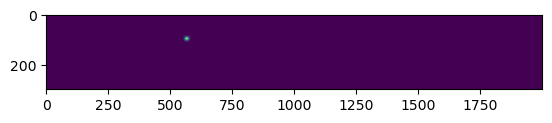

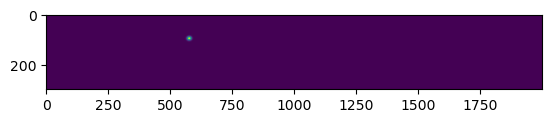

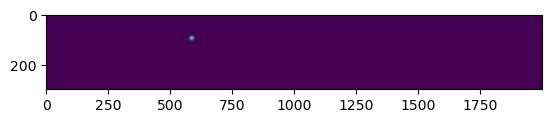

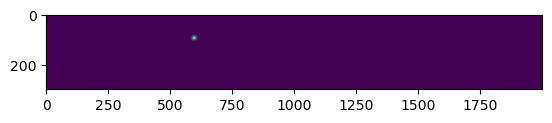

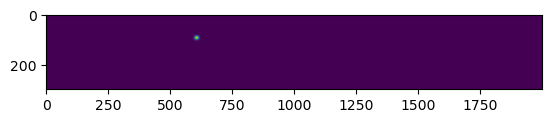

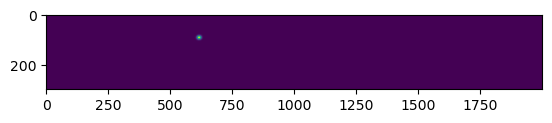

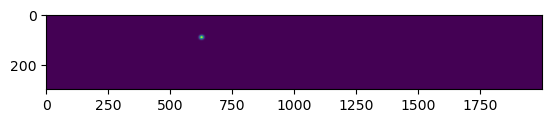

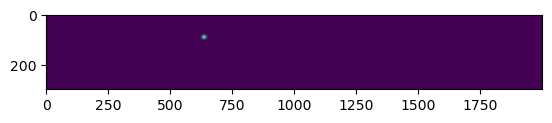

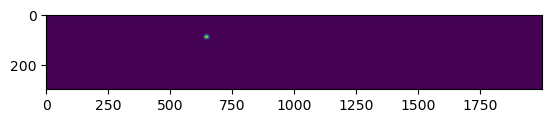

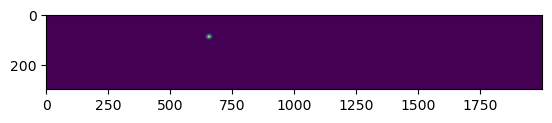

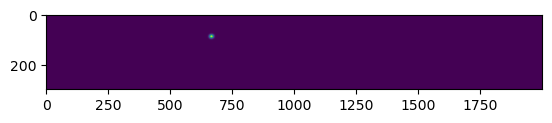

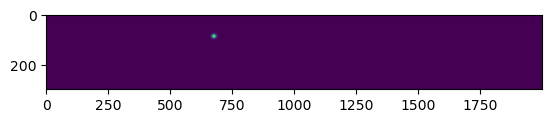

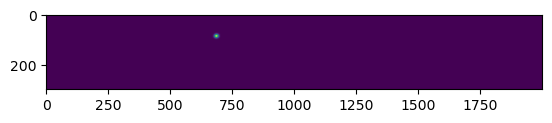

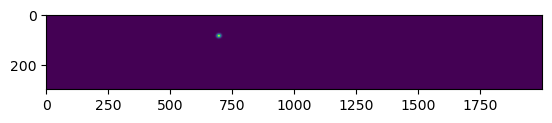

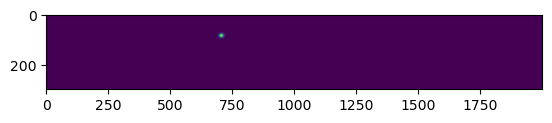

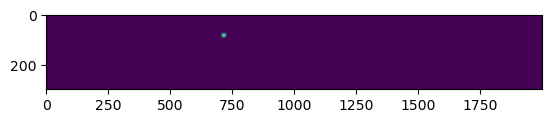

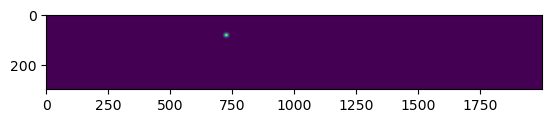

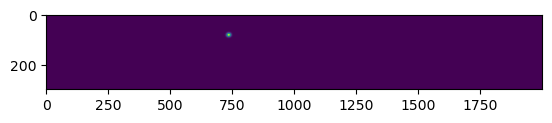

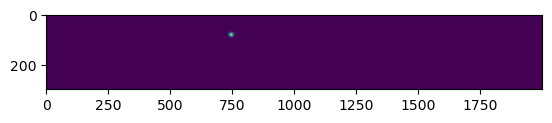

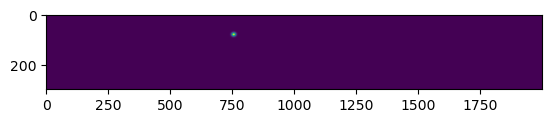

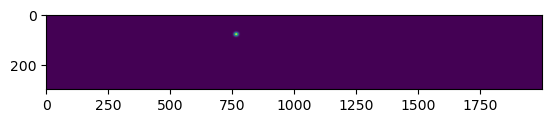

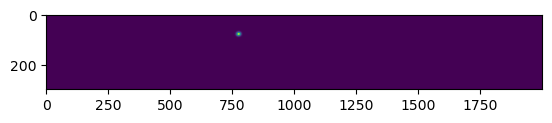

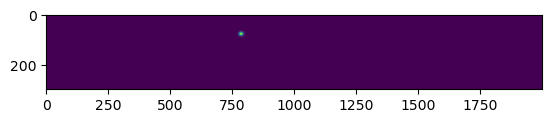

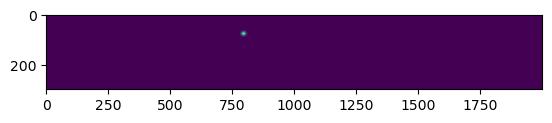

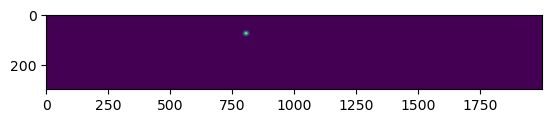

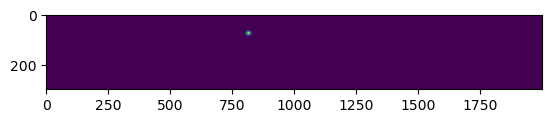

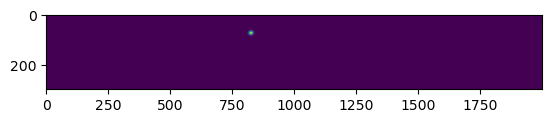

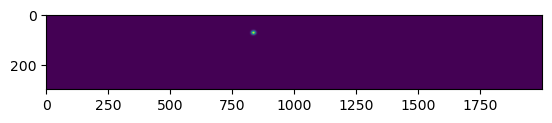

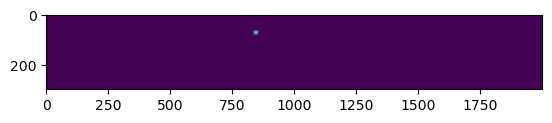

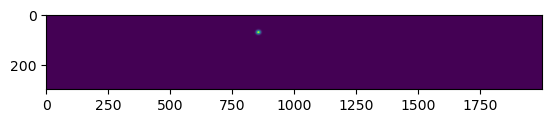

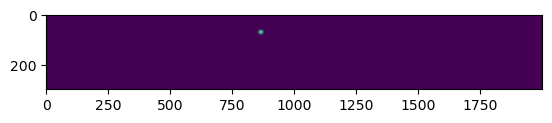

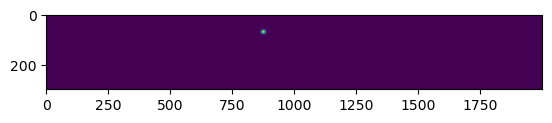

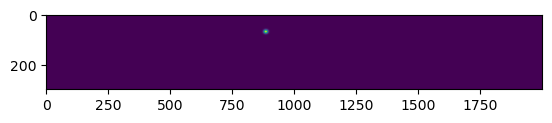

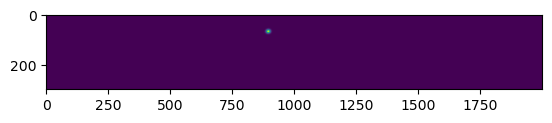

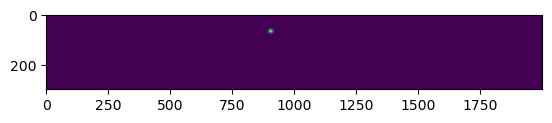

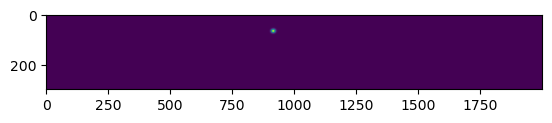

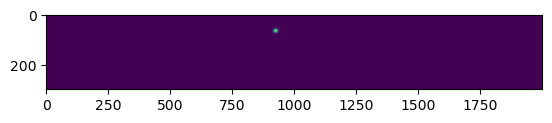

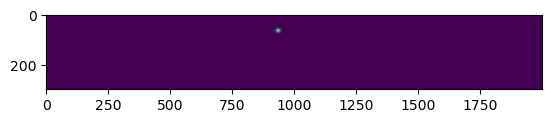

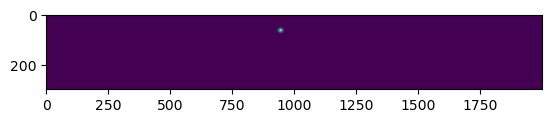

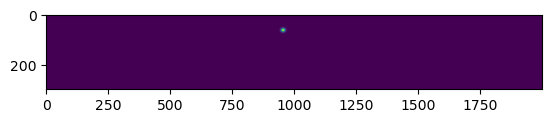

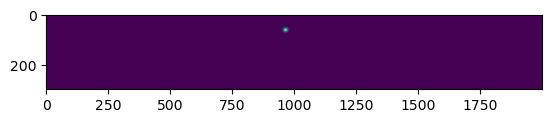

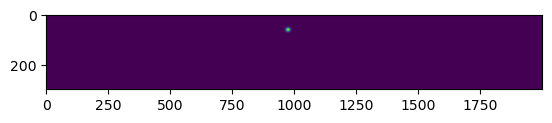

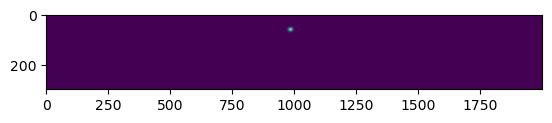

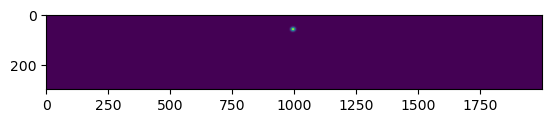

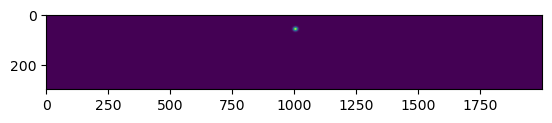

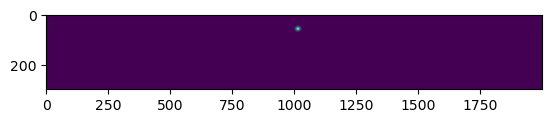

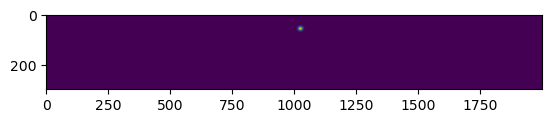

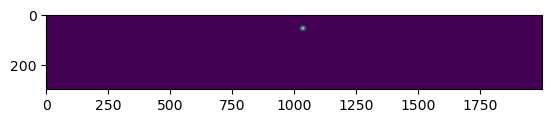

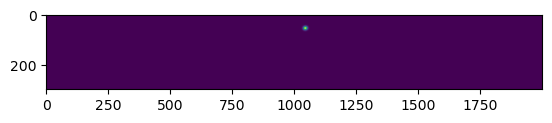

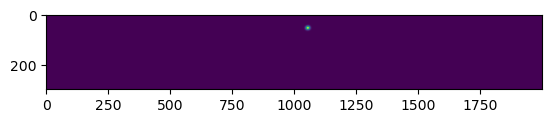

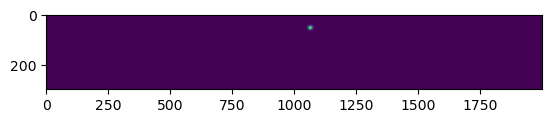

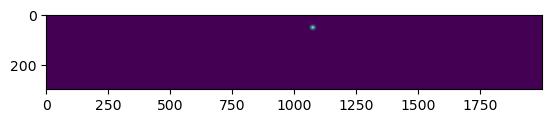

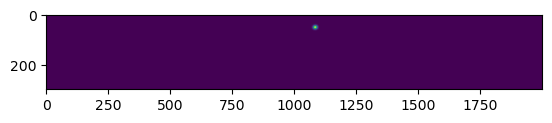

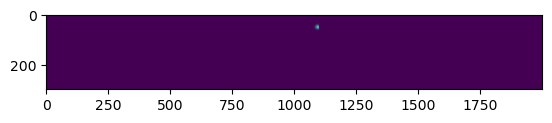

In [35]:
# make cubes of command-response pairs

# retrieve white-light pattern
#A_mat, test_cmds, test_response = pickle.load(open_file)
#open_file.close()

N_cmd = 100
step_wavel = int(1000/N_cmd) # step size of impulse on detector, in pixels
x_detec_size = 300
y_detec_size = 2000

N_pixels = x_detec_size*y_detec_size
cube_w_step_impulse = np.zeros((100,x_detec_size,y_detec_size))
cube_w_commands = np.zeros((N_cmd,N_cmd))

M_basis_set_cmds = N_cmd
poke_matrix = np.zeros((N_pixels,M_basis_set_cmds))

for t in range(0,N_cmd):
    
    vec_command = np.zeros(N_cmd)
    
    # update command vector
    vec_command[t] = 1
    
    # make the fake responses
    blank_2d = np.zeros((101,1000))
    spec_perfect = blank_2d
    
    # an actual stellar spectrum
    #spec_perfect[51,t*step_wavel:(t+1)*step_wavel] = np.array(spec_fake['flux_norm'])[t*step_wavel:(t+1)*step_wavel]
    
    # a white light spectrum
    spec_perfect[51,t*step_wavel:(t+1)*step_wavel] = norm_val*np.ones(len(spec_fake['flux_norm']))[t*step_wavel:(t+1)*step_wavel]
    
    spec_convolved = gaussian_filter(spec_perfect, sigma=5)

    #plt.imshow(spec_convolved)
    #plt.show()

    test_rotate = scipy.ndimage.rotate(spec_convolved, 5)
    
    '''
    # noisy background
    array_2d_substrate = 0.01*np.random.normal(size=(x_detec_size,y_detec_size))
    '''
    # no noise
    array_2d_substrate = np.zeros((x_detec_size,y_detec_size))
    
    array_2d_w_spec = np.copy(array_2d_substrate)
    del_x = np.shape(test_rotate)[0]
    del_y = np.shape(test_rotate)[1]
    array_2d_w_spec[0:0+del_x,100:100+del_y] += test_rotate
    
    #print(np.shape(array_2d_w_spec))
    #print()
    
    test_response = np.copy(array_2d_w_spec) # cosmetic
    
    #print(np.shape(test_response))
    
    # accumulate flattened responses
    flattened = test_response.flatten()
    # each column is one 'poke', and the elements are the response function
    poke_matrix[:,t] = flattened
    #poke_matrix[i,:] = flattened


    plt.imshow(array_2d_w_spec)
    plt.show()

    
    # add commands to cube
    cube_w_commands[t,:] = vec_command
    
    # add frame to cube
    cube_w_step_impulse[t,:,:] = array_2d_w_spec

In [36]:
# pseudoinverse: the instrument response matrix
response_matrix = np.linalg.pinv(poke_matrix)

In [23]:
# write to FITS to check

'''
hdu = fits.PrimaryHDU(cube_w_step_impulse)
hdul = fits.HDUList([hdu])
hdul.writeto('junk.fits')
'''

In [37]:
# pickle the data array with the white light spectrum

test_response = cube_w_step_impulse
test_cmds = cube_w_commands
response_matrix = response_matrix

# pickle stuff
data_list = [response_matrix, test_cmds, test_response]
file_name = "junk_white_light_no_noise.pkl"
open_file = open(file_name, "wb")
pickle.dump(data_list, open_file)
open_file.close()

In [25]:
# pickle the 2D data array with the stellar spectrum

# pickle stuff
data_list = [array_2d_w_spec]
file_name = "junk_stellar_empirical_no_noise.pkl"
open_file = open(file_name, "wb")
pickle.dump(data_list, open_file)
open_file.close()